In [7]:
from os.path import join
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn import plotting
import numpy as np
import pandas as pd
from sec_lev_design_matrix import SecLevDesignMat

## Create a second level design matrix

First set a few relevant variables:

In [8]:
DATADIR = "second_level_input"
SUBJECTS = 2
COND = ["f_col", "f_high", "f_low", "f_pl", "nf_col", "nf_high", "nf_low", "nf_pl"]

Now we create the design matrix by using the class SecLevDesignMat and we plot it

[[1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]]


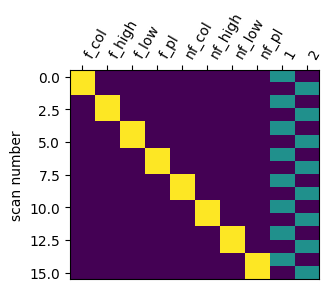

In [9]:
des_mat = SecLevDesignMat(SUBJECTS, COND)
des_mat.plot_dm()

Now we check whether the matrix is fine, meaning whether is **full rank**, otherwise we cannot properly do our regression (matrix is not invertable and we can get wrong results, there is no unique result)

In [10]:
des_mat.check_matrix_rank()

matrix is not full rank,
            make it as full rank to avoid erratic results


,f_col,f_high,f_low,f_pl,nf_col,nf_high,nf_low,nf_pl,1,2
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


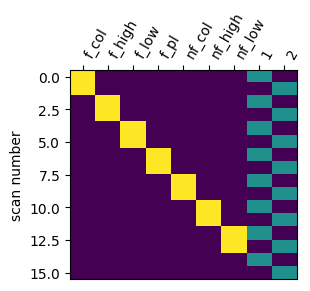

In [11]:
dm = des_mat.mk_full_rank("nf_pl")
des_mat.plot_dm(dm)

## Set up the second level model and fit it 

In [12]:
SL = SecondLevelModel(smoothing_fwhm=6.0)

second_level_model = SL.fit(
    second_level_input=[
        nib.load(
            join(
                DATADIR,
                f"sub-{sub:02}",
                f"sub-{sub:02}_{cond}_fixed_effects.nii.gz",
            )
        )
        for sub in range(1, SUBJECTS + 1)
        for cond in COND
    ],
    design_matrix=dm,
)


## Make relevant contrasts by using a python dictionary

In [13]:
def mk_contrasts(conditions, subjects):
    """ """
    contrast_matrix = np.eye(len(conditions))
    return {
        column: np.hstack([contrast_matrix[i], np.zeros(subjects)])
        for i, column in enumerate(conditions)
    }
print(COND[:-1])
CONTRASTS = mk_contrasts(COND[:-1], SUBJECTS)
print(CONTRASTS)

['f_col', 'f_high', 'f_low', 'f_pl', 'nf_col', 'nf_high', 'nf_low']
{'f_col': array([1., 0., 0., 0., 0., 0., 0., 0., 0.]), 'f_high': array([0., 1., 0., 0., 0., 0., 0., 0., 0.]), 'f_low': array([0., 0., 1., 0., 0., 0., 0., 0., 0.]), 'f_pl': array([0., 0., 0., 1., 0., 0., 0., 0., 0.]), 'nf_col': array([0., 0., 0., 0., 1., 0., 0., 0., 0.]), 'nf_high': array([0., 0., 0., 0., 0., 1., 0., 0., 0.]), 'nf_low': array([0., 0., 0., 0., 0., 0., 1., 0., 0.])}


In [14]:
ALL_CONTR = {
    "f_vs_nf": (
        CONTRASTS["f_col"]
        + CONTRASTS["f_high"]
        + CONTRASTS["f_low"]
        + CONTRASTS["f_pl"]
    )
    - (CONTRASTS["nf_col"] + CONTRASTS["nf_high"] + CONTRASTS["nf_low"])
}
print(ALL_CONTR)

{'f_vs_nf': array([ 1.,  1.,  1.,  1., -1., -1., -1.,  0.,  0.])}


## Run each single contrast, threshold and save data

In [15]:
OUTPUT = "second_lev_f_vs_nf.nii.gz"
for contr_name, contr in ALL_CONTR.items():
    print(f"running {contr_name} contrast")
    res = second_level_model.compute_contrast(contr, "stat", "t")
    # threshold the map and correct for multiple comparisons
    thresholded_map, threshold = threshold_stats_img(
        res,
        alpha=0.05,
        height_control="fpr",
        cluster_threshold=10,
        two_sided=True,
    )
    thresholded_map.to_filename(OUTPUT)

running f_vs_nf contrast


## Let's plot the results and save the plot

-4.2302340758892365 4.233735082687416


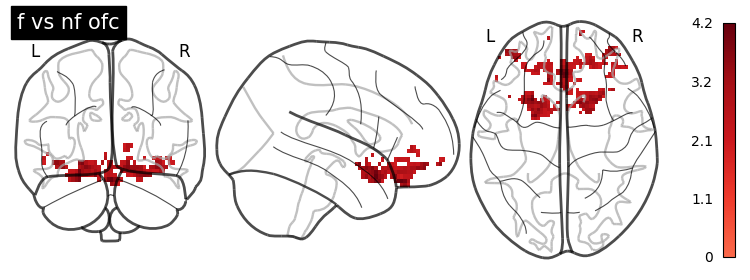

In [19]:
mask = "/home/emanuele/Documents/bnb_retreat/data/masks/binarized_ofc.nii.gz"

def mask_data(img, mask):
    """mask your results"""
    mask = nib.load(mask)
    affine = img.affine
    header = nib.Nifti1Header()
    mult = img.get_fdata() * mask.get_fdata()
    print(mult.min(), mult.max())
    return nib.Nifti1Image(mult, affine, header)

plotting.plot_glass_brain(
        mask_data(thresholded_map, mask),
        cmap="Reds",
        colorbar=True,
        title="f vs nf ofc",
    )
plt.savefig("f_vs_nf.png")